In [0]:
spark.conf.set(
    "fs.azure.account.key.capstoneg7.blob.core.windows.net",
    "EMwjEmmSadGVl1SGKR2zmccXiP2If5QGN7M6MdI3Ng/WDisQLrsv+LxnHbQ6sFJVpUR175vJDAEf+ASt1xgtpQ=="
)

# sanity check: you should see folders/files
display(dbutils.fs.ls("wasbs://environment@capstoneg7.blob.core.windows.net/"))
display(dbutils.fs.ls("wasbs://environment@capstoneg7.blob.core.windows.net/silver/"))


path,name,size,modificationTime
wasbs://environment@capstoneg7.blob.core.windows.net/bronze/,bronze/,0,0
wasbs://environment@capstoneg7.blob.core.windows.net/silver/,silver/,0,1762861564000


path,name,size,modificationTime
wasbs://environment@capstoneg7.blob.core.windows.net/silver/air_quality_clean/,air_quality_clean/,0,1762861564000


In [0]:
# 0) Auth for BLOB (wasbs)
spark.conf.set(
    "fs.azure.account.key.capstoneg7.blob.core.windows.net",
    "EMwjEmmSadGVl1SGKR2zmccXiP2If5QGN7M6MdI3Ng/WDisQLrsv+LxnHbQ6sFJVpUR175vJDAEf+ASt1xgtpQ=="
)

USE_WASBS = True  # you're on wasbs

from pyspark.sql import functions as F
from pyspark.sql.window import Window

storage = "capstoneg7"

silver = f"wasbs://environment@{storage}.blob.core.windows.net/silver/air_quality_clean"
gold   = f"wasbs://environment@{storage}.blob.core.windows.net/gold/air_quality_monthly"

# 1) READ AS DELTA because silver has _delta_log
df = spark.read.format("delta").load(silver)

# 2) Aggregations
monthly = (df.groupBy("city","year","month")
             .agg(F.avg("pm25").alias("pm25_avg")))

w = Window.partitionBy("city").orderBy("year","month").rowsBetween(-2,0)
monthly = monthly.withColumn("pm25_avg_3mo", F.avg("pm25_avg").over(w))

# 3) You can WRITE gold as Parquet (fine) or Delta (also fine)
(monthly.write.format("parquet").mode("overwrite").save(gold))

display(monthly.orderBy("city","year","month").limit(20))


city,year,month,pm25_avg,pm25_avg_3mo
Ahmedabad,2015,1,82.6825,82.6825
Ahmedabad,2015,2,116.1016,99.39205000000001
Ahmedabad,2015,3,110.46933333333335,103.08447777777779
Ahmedabad,2015,4,101.68199999999999,109.41764444444443
Ahmedabad,2015,5,74.91935483870968,95.69022939068101
Ahmedabad,2015,6,48.97366666666665,75.19167383512543
Ahmedabad,2015,7,52.41967741935484,58.77089964157707
Ahmedabad,2015,8,40.88,47.42444802867383
Ahmedabad,2015,9,42.311379310344826,45.203685576566556
Ahmedabad,2015,10,109.77064516129032,64.32067482387838


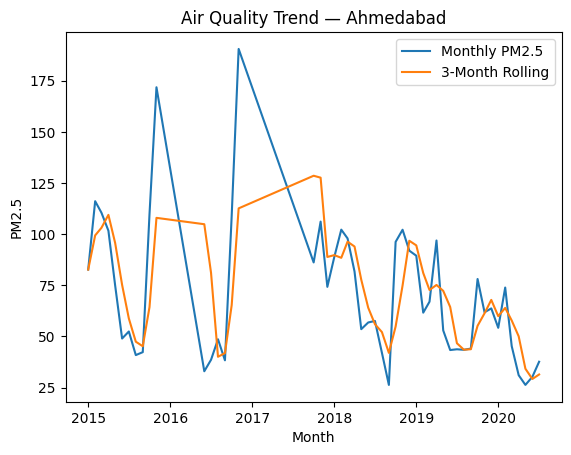

In [0]:
# --- Trend chart ---
import pandas as pd
import matplotlib.pyplot as plt

# convert to pandas in time order
pdf = monthly.orderBy("city","year","month").toPandas()

# pick a city present in your data (or hardcode one you know exists)
city = pdf["city"].dropna().unique()[0]
sub  = pdf[pdf["city"] == city].copy()
sub["date"] = pd.to_datetime(sub["year"].astype(str) + "-" + sub["month"].astype(str) + "-01")

plt.figure()
plt.plot(sub["date"], sub["pm25_avg"], label="Monthly PM2.5")
if "pm25_avg_3mo" in sub.columns:
    plt.plot(sub["date"], sub["pm25_avg_3mo"], label="3-Month Rolling")
plt.title(f"Air Quality Trend — {city}")
plt.xlabel("Month"); plt.ylabel("PM2.5"); plt.legend()
plt.show()


In [0]:
# 1 - Authenticate to Blob (wasbs)
storage = "capstoneg7"   # your storage name
blob_endpoint = f"{storage}.blob.core.windows.net"
spark.conf.set(
    f"fs.azure.account.key.{blob_endpoint}",
    "EMwjEmmSadGVl1SGKR2zmccXiP2If5QGN7M6MdI3Ng/WDisQLrsv+LxnHbQ6sFJVpUR175vJDAEf+ASt1xgtpQ=="
)

# sanity list
print("Listing root container:")
display(dbutils.fs.ls(f"wasbs://environment@{blob_endpoint}/"))

print("Listing bronze folder:")
display(dbutils.fs.ls(f"wasbs://environment@{blob_endpoint}/bronze/"))
print("Listing silver folder:")
display(dbutils.fs.ls(f"wasbs://environment@{blob_endpoint}/silver/"))


Listing root container:


path,name,size,modificationTime
wasbs://environment@capstoneg7.blob.core.windows.net/bronze/,bronze/,0,0
wasbs://environment@capstoneg7.blob.core.windows.net/gold/,gold/,0,1762863020000
wasbs://environment@capstoneg7.blob.core.windows.net/silver/,silver/,0,1762861564000


Listing bronze folder:


path,name,size,modificationTime
wasbs://environment@capstoneg7.blob.core.windows.net/bronze/city_day.csv,city_day.csv,2574056,1762840784000


Listing silver folder:


path,name,size,modificationTime
wasbs://environment@capstoneg7.blob.core.windows.net/silver/air_quality_clean/,air_quality_clean/,0,1762861564000


In [0]:
from pyspark.sql.utils import AnalysisException

silver_path = f"wasbs://environment@{blob_endpoint}/silver/air_quality_clean"
files = dbutils.fs.ls(silver_path)
for f in files:
    print(f.name)

# quick detection
is_delta = any(f.name == "_delta_log/" for f in files)
print("is_delta:", is_delta)


_delta_log/
year=2015/
year=2016/
year=2017/
year=2018/
year=2019/
year=2020/
is_delta: True


In [0]:
# read delta, write parquet copy
from pyspark.sql import functions as F

print("Reading delta from silver ...")
df_delta = spark.read.format("delta").load(silver_path)   # may require correct key (we set blob key above)
print("Writing parquet copy to silver_parquet ...")
parquet_path = f"wasbs://environment@{blob_endpoint}/silver_parquet/air_quality_clean"
df_delta.write.mode("overwrite").partitionBy("year","month").parquet(parquet_path)

display(dbutils.fs.ls(f"wasbs://environment@{blob_endpoint}/silver_parquet/"))


Reading delta from silver ...
Writing parquet copy to silver_parquet ...


path,name,size,modificationTime
wasbs://environment@capstoneg7.blob.core.windows.net/silver_parquet/air_quality_clean/,air_quality_clean/,0,1763055140000


In [0]:
# make a parquet copy of the delta table (keeps original)
from pyspark.sql import functions as F

storage = "capstoneg7"
blob_endpoint = f"{storage}.blob.core.windows.net"

# set blob key
spark.conf.set(
    f"fs.azure.account.key.{blob_endpoint}",
    "EMwjEmmSadGVl1SGKR2zmccXiP2If5QGN7M6MdI3Ng/WDisQLrsv+LxnHbQ6sFJVpUR175vJDAEf+ASt1xgtpQ=="
)

silver_delta_path = f"wasbs://environment@{blob_endpoint}/silver/air_quality_clean"
parquet_copy_path = f"wasbs://environment@{blob_endpoint}/silver_parquet/air_quality_clean"

# read delta and write parquet partitioned (year/month)
df_delta = spark.read.format("delta").load(silver_delta_path)
df_delta.write.mode("overwrite").partitionBy("year","month").parquet(parquet_copy_path)
display(dbutils.fs.ls(parquet_copy_path))


path,name,size,modificationTime
wasbs://environment@capstoneg7.blob.core.windows.net/silver_parquet/air_quality_clean/_SUCCESS,_SUCCESS,0,1763055594000
wasbs://environment@capstoneg7.blob.core.windows.net/silver_parquet/air_quality_clean/_committed_5383601472232540632,_committed_5383601472232540632,35,1763055594000
wasbs://environment@capstoneg7.blob.core.windows.net/silver_parquet/air_quality_clean/year=2015/,year=2015/,0,1763055136000
wasbs://environment@capstoneg7.blob.core.windows.net/silver_parquet/air_quality_clean/year=2016/,year=2016/,0,1763055136000
wasbs://environment@capstoneg7.blob.core.windows.net/silver_parquet/air_quality_clean/year=2017/,year=2017/,0,1763055136000
wasbs://environment@capstoneg7.blob.core.windows.net/silver_parquet/air_quality_clean/year=2018/,year=2018/,0,1763055136000
wasbs://environment@capstoneg7.blob.core.windows.net/silver_parquet/air_quality_clean/year=2019/,year=2019/,0,1763055136000
wasbs://environment@capstoneg7.blob.core.windows.net/silver_parquet/air_quality_clean/year=2020/,year=2020/,0,1763055136000


In [0]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

parquet_src = f"wasbs://environment@{blob_endpoint}/silver_parquet/air_quality_clean"
df = spark.read.parquet(parquet_src)

# normalize columns & compute monthly (same as above)
for c in df.columns:
    df = df.withColumnRenamed(c, c.strip())

if "PM2.5" in df.columns:
    df = df.withColumnRenamed("PM2.5","pm25")
elif "pm25" not in df.columns:
    print("Columns found:", df.columns)
    raise Exception("pm25 column not found. Adjust the column name accordingly.")

if "date" not in df.columns:
    if "Date" in df.columns:
        df = df.withColumn("date", F.to_date("Date"))
    else:
        raise Exception("No date column found; check CSV schema.")

df = df.dropDuplicates().filter(F.col("pm25").isNotNull() & (F.col("pm25") < 1000))
if "year" not in df.columns:
    df = df.withColumn("year", F.year("date"))
if "month" not in df.columns:
    df = df.withColumn("month", F.month("date"))

monthly = (
    df.groupBy("city","year","month")
      .agg(F.avg("pm25").alias("pm25_avg"))
)
w = Window.partitionBy("city").orderBy("year","month").rowsBetween(-2,0)
monthly = monthly.withColumn("pm25_avg_3mo", F.avg("pm25_avg").over(w))

display(monthly.orderBy("city","year","month").limit(20))


city,year,month,pm25_avg,pm25_avg_3mo
Ahmedabad,2015,1,82.6825,82.6825
Ahmedabad,2015,2,116.1016,99.39205000000001
Ahmedabad,2015,3,110.46933333333332,103.08447777777779
Ahmedabad,2015,4,101.682,109.41764444444443
Ahmedabad,2015,5,74.91935483870968,95.690229390681
Ahmedabad,2015,6,48.97366666666667,75.19167383512546
Ahmedabad,2015,7,52.419677419354834,58.77089964157705
Ahmedabad,2015,8,40.88000000000001,47.42444802867383
Ahmedabad,2015,9,42.31137931034483,45.203685576566556
Ahmedabad,2015,10,109.77064516129033,64.32067482387839


In [0]:
jdbc_hostname = "capstone07server.database.windows.net"   # ✅ match exactly as shown in SSMS
jdbc_database = "Capstone_db"                              # ✅ match exact casing
jdbc_port = 1433

jdbc_url = f"jdbc:sqlserver://{jdbc_hostname}:{jdbc_port};database={jdbc_database};encrypt=true;trustServerCertificate=false;loginTimeout=30;"

connection_properties = {
    "user": "sqladmin",
    "password": "Admin@123",  # replace with your actual password
    "driver": "com.microsoft.sqlserver.jdbc.SQLServerDriver"
}

# Quick connectivity test
try:
    test_df = spark.read \
        .format("jdbc") \
        .option("url", jdbc_url) \
        .option("query", "SELECT TOP (1) 1 AS testcol") \
        .options(**connection_properties) \
        .load()
    display(test_df)
    print("✅ Connection to Azure SQL succeeded.")
except Exception as e:
    print("❌ Connection failed. See details below:")
    import traceback, sys
    traceback.print_exc(file=sys.stdout)


testcol
1


✅ Connection to Azure SQL succeeded.


In [0]:
# Write data to SQL (overwrite existing table or create new one)
monthly.write.jdbc(
    url=jdbc_url,
    table="dbo.air_quality_monthly",
    mode="overwrite",   # use 'append' if you don't want to overwrite
    properties=connection_properties
)

print("✅ Data successfully written to Azure SQL.")


✅ Data successfully written to Azure SQL.


In [0]:
# ---------- CONFIG - update ONLY these values ----------
storage = "capstoneg7"                            # your storage account name
blob_endpoint = f"{storage}.blob.core.windows.net"

jdbc_hostname = "capstone07server.database.windows.net"   # exact server name
jdbc_database = "Capstone_db"                              # exact database name
jdbc_port = 1433

jdbc_url = f"jdbc:sqlserver://{jdbc_hostname}:{jdbc_port};database={jdbc_database};encrypt=true;trustServerCertificate=false;loginTimeout=30;"

sql_user = "sqladmin"
sql_password = "Admin@123"  # <<< paste here (do not share)

jdbc_props = {
  "user": sql_user,
  "password": sql_password,
  "driver": "com.microsoft.sqlserver.jdbc.SQLServerDriver"
}

# set storage key for wasbs (session-scoped)
spark.conf.set(
    f"fs.azure.account.key.{blob_endpoint}",
    "EMwjEmmSadGVl1SGKR2zmccXiP2If5QGN7M6MdI3Ng/WDisQLrsv+LxnHbQ6sFJVpUR175vJDAEf+ASt1xgtpQ=="   # <<< paste your storage account key here
)

# sanity listing (optional)
print("Bronze folder listing:")
display(dbutils.fs.ls(f"wasbs://environment@{blob_endpoint}/bronze/"))


Bronze folder listing:


path,name,size,modificationTime
wasbs://environment@capstoneg7.blob.core.windows.net/bronze/city_day.csv,city_day.csv,2574056,1762840784000


In [0]:
# Read raw bronze CSV
bronze_path = f"wasbs://environment@{blob_endpoint}/bronze/city_day.csv"

raw_df = (spark.read
          .option("header", True)
          .option("inferSchema", False)   # keep as strings for maximum safety
          .option("multiLine", False)
          .option("mode", "PERMISSIVE")
          .csv(bronze_path))

# Trim column names (defensive)
for c in raw_df.columns:
    nc = c.strip()
    if nc != c:
        raw_df = raw_df.withColumnRenamed(c, nc)

print("Columns:", raw_df.columns)
print("Row count (bronze):", raw_df.count())
display(raw_df.limit(5))


Columns: ['City', 'Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket']
Row count (bronze): 29531


City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
Ahmedabad,2015-01-01,null,null,0.92,18.22,17.15,null,0.92,27.64,133.36,0.0,0.02,0.0,null,null
Ahmedabad,2015-01-02,null,null,0.97,15.69,16.46,null,0.97,24.55,34.06,3.68,5.5,3.77,null,null
Ahmedabad,2015-01-03,null,null,17.4,19.3,29.7,null,17.4,29.07,30.7,6.8,16.4,2.25,null,null
Ahmedabad,2015-01-04,null,null,1.7,18.48,17.97,null,1.7,18.59,36.08,4.43,10.14,1.0,null,null
Ahmedabad,2015-01-05,null,null,22.1,21.42,37.76,null,22.1,39.33,39.31,7.01,18.89,2.78,null,null


In [0]:
from pyspark.sql.functions import col

# rename Date to DateRaw to avoid SQL reserved keyword confusion
if "Date" in raw_df.columns and "DateRaw" not in raw_df.columns:
    raw_df = raw_df.withColumnRenamed("Date", "DateRaw")

display(raw_df.select("City","DateRaw").limit(10))


City,DateRaw
Ahmedabad,2015-01-01
Ahmedabad,2015-01-02
Ahmedabad,2015-01-03
Ahmedabad,2015-01-04
Ahmedabad,2015-01-05
Ahmedabad,2015-01-06
Ahmedabad,2015-01-07
Ahmedabad,2015-01-08
Ahmedabad,2015-01-09
Ahmedabad,2015-01-10


In [0]:
storage = "capstoneg7"
blob_endpoint = f"{storage}.blob.core.windows.net"

jdbc_hostname = "capstone07server.database.windows.net"
jdbc_database = "Capstone_db"
jdbc_port = 1433

jdbc_url = f"jdbc:sqlserver://{jdbc_hostname}:{jdbc_port};database={jdbc_database};encrypt=true;trustServerCertificate=false;loginTimeout=30;"

jdbc_props = {
    "user": "sqladmin",
    "password": "Admin@123",
    "driver": "com.microsoft.sqlserver.jdbc.SQLServerDriver"
}

# Storage key for Blob
spark.conf.set(
    f"fs.azure.account.key.{blob_endpoint}",
    "<YOUR_STORAGE_KEY>"
)

print("Setup completed.")


Setup completed.


In [0]:
from pyspark.sql import functions as F

bronze_path = f"wasbs://environment@{blob_endpoint}/bronze/city_day.csv"

# Read the raw CSV (Bronze)
raw_df = (
    spark.read
        .option("header", True)
        .option("inferSchema", False)   # keep all as strings
        .csv(bronze_path)
)

# Clean column names
for c in raw_df.columns:
    nc = c.strip()
    if nc != c:
        raw_df = raw_df.withColumnRenamed(c, nc)

# Rename Date → DateRaw (avoid SQL keyword)
if "Date" in raw_df.columns:
    raw_df = raw_df.withColumnRenamed("Date", "DateRaw")

# Cast EVERYTHING to string (to avoid SQL type issues)
raw_str_df = raw_df.select([F.col(c).cast("string").alias(c) for c in raw_df.columns])

print("raw_str_df ready. Row count:", raw_str_df.count())
display(raw_str_df.limit(5))


---------------------------------------------------------------------------
Py4JJavaError                             Traceback (most recent call last)
File <command-4836175900126334>, line 10
      3 bronze_path = f"wasbs://environment@{blob_endpoint}/bronze/city_day.csv"
      5 # Read the raw CSV (Bronze)
      6 raw_df = (
      7     spark.read
      8         .option("header", True)
      9         .option("inferSchema", False)   # keep all as strings
---> 10         .csv(bronze_path)
     11 )
     13 # Clean column names
     14 for c in raw_df.columns:

File /databricks/spark/python/pyspark/instrumentation_utils.py:47, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     45 start = time.perf_counter()
     46 try:
---> 47     res = func(*args, **kwargs)
     48     logger.log_success(
     49         module_name, class_name, function_name, time.perf_counter() - start, signature
     50     )
     51     return res

File /databricks/spark/python/pyspark/sql/readwriter.py:83

**TIME SERIES FORECASTING OPERATION**


In [0]:
dbutils.library.restartPython()

In [0]:
# CONFIG - update only secrets
storage = "capstoneg7"
blob_endpoint = f"{storage}.blob.core.windows.net"

jdbc_hostname = "capstone07server.database.windows.net"
jdbc_database = "Capstone_db"
jdbc_port = 1433

jdbc_url = f"jdbc:sqlserver://{jdbc_hostname}:{jdbc_port};database={jdbc_database};encrypt=true;trustServerCertificate=false;loginTimeout=30;"
jdbc_props = {"user":"sqladmin", "password":"Admin@123", "driver":"com.microsoft.sqlserver.jdbc.SQLServerDriver"}

# If you need to access adls/blob from notebook:
spark.conf.set(f"fs.azure.account.key.{blob_endpoint}", "EMwjEmmSadGVl1SGKR2zmccXiP2If5QGN7M6MdI3Ng/WDisQLrsv+LxnHbQ6sFJVpUR175vJDAEf+ASt1xgtpQ==")  # or use SAS


In [0]:
storage = "capstoneg7"
blob_endpoint = f"{storage}.blob.core.windows.net"

spark.conf.set(
    f"fs.azure.account.key.{blob_endpoint}",
    "EMwjEmmSadGVl1SGKR2zmccXiP2If5QGN7M6MdI3Ng/WDisQLrsv+LxnHbQ6sFJVpUR175vJDAEf+ASt1xgtpQ=="   # from portal → Storage account → Access keys → key1
)


In [0]:
from pyspark.sql import functions as F

silver_path = "wasbs://environment@capstoneg7.blob.core.windows.net/silver/air_quality_clean"

df = spark.read.format("delta").load(silver_path)

df = (df.withColumn("date", F.to_date("date"))
        .withColumn("pm25", F.col("pm25").cast("double"))
        .select("city","date","pm25"))

display(df.limit(5))


city,date,pm25
Delhi,2015-02-06,151.6
Delhi,2015-02-13,167.01
Ahmedabad,2015-02-21,239.96
Delhi,2015-02-27,130.42
Delhi,2015-02-25,148.19


In [0]:
# CELL A - Imports, Params, Small Helpers
from pyspark.sql import functions as F
import pandas as pd, numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Parameters
TOP_N = 10
H = 30   # forecast horizon days

# Metric helpers
def mae(y_true, y_pred): return mean_absolute_error(y_true, y_pred)
def rmse(y_true, y_pred): return mean_squared_error(y_true, y_pred, squared=False)
def mape(y_true, y_pred):
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true==0,1e-8,y_true))) * 100


In [0]:
# CELL B - convert Spark df → pandas and pick top cities
# df already exists (silver read output). Ensure required columns exist:
assert set(['city','date','pm25']).issubset(set(df.columns)), "df must have columns city,date,pm25"

# get top cities by row count
counts = df.groupBy("city").count().orderBy(F.desc("count")).limit(TOP_N).toPandas()
top_cities = counts['city'].tolist()
print("Top cities:", top_cities)

# load needed subset to pandas for modeling
pdf = df.filter(F.col("city").isin(top_cities)).select("city","date","pm25").orderBy("city","date").toPandas()
pdf['date'] = pd.to_datetime(pdf['date'])


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-4804739986917978>, line 3
      1 # CELL B - convert Spark df → pandas and pick top cities
      2 # df already exists (silver read output). Ensure required columns exist:
----> 3 assert set(['city','date','pm25']).issubset(set(df.columns)), "df must have columns city,date,pm25"
      5 # get top cities by row count
      6 counts = df.groupBy("city").count().orderBy(F.desc("count")).limit(TOP_N).toPandas()

NameError: name 'df' is not defined

In [0]:
# CELL C — series reindex & imputation helper
def make_city_daily(city_pdf):
    # city_pdf: pandas DataFrame with date, pm25
    city_pdf = city_pdf.sort_values('date').set_index('date')
    idx = pd.date_range(start=city_pdf.index.min(), end=city_pdf.index.max(), freq='D')
    s = city_pdf.reindex(idx)
    s.index.name = 'date'
    # interpolate then forward/backward fill
    s['pm25'] = s['pm25'].interpolate().fillna(method='ffill').fillna(method='bfill')
    return s.reset_index()


In [0]:
# CELL D (run only if needed) - Installation of Library
%pip install pmdarima prophet scikit-learn statsmodels --quiet
print("Installed libs - restart python if required.")


Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Installed libs - restart python if required.


In [0]:
dbutils.library.restartPython()

In [0]:
# CELL E - model functions (auto_arima & Prophet)
import pmdarima as pm
from prophet import Prophet

def arima_forecast(train_series, h=30, seasonal=True, m=7):
    model = pm.auto_arima(train_series, seasonal=seasonal, m=m, stepwise=True,
                          max_p=5, max_q=5, max_P=2, max_Q=2,
                          suppress_warnings=True, error_action='ignore')
    fc = model.predict(n_periods=h)
    return fc, model

def prophet_forecast(train_df, h=30):
    dfp = train_df.rename(columns={'date':'ds','pm25':'y'})[['ds','y']]
    m = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
    m.fit(dfp)
    future = m.make_future_dataframe(periods=h, freq='D')
    forecast = m.predict(future)
    out = forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(h).rename(columns={'ds':'date'})
    return out, m


In [0]:
from pyspark.sql import functions as F

# Load SILVER cleaned dataset
silver_path = "wasbs://environment@capstoneg7.blob.core.windows.net/silver/air_quality_clean"

df = spark.read.format("delta").load(silver_path)

# Ensure proper types
df = (
    df.withColumn("date", F.to_date("date"))
      .withColumn("pm25", F.col("pm25").cast("double"))
      .select("city", "date", "pm25")
)

display(df.limit(5))


city,date,pm25
Delhi,2015-02-06,151.6
Delhi,2015-02-13,167.01
Ahmedabad,2015-02-21,239.96
Delhi,2015-02-27,130.42
Delhi,2015-02-25,148.19


In [0]:
# CELL A - Imports, Params, Small Helpers
from pyspark.sql import functions as F
import pandas as pd, numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Parameters
TOP_N = 10
H = 30   # forecast horizon days

# Metric helpers
def mae(y_true, y_pred): return mean_absolute_error(y_true, y_pred)
def rmse(y_true, y_pred): return mean_squared_error(y_true, y_pred, squared=False)
def mape(y_true, y_pred):
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true==0,1e-8,y_true))) * 100

In [0]:
# CELL B
# df already exists (silver read output). Ensure required columns exist:
assert set(['city','date','pm25']).issubset(set(df.columns)), "df must have columns city,date,pm25"

# get top cities by row count
counts = df.groupBy("city").count().orderBy(F.desc("count")).limit(TOP_N).toPandas()
top_cities = counts['city'].tolist()
print("Top cities:", top_cities)

# load needed subset to pandas for modeling
pdf = df.filter(F.col("city").isin(top_cities)).select("city","date","pm25").orderBy("city","date").toPandas()
pdf['date'] = pd.to_datetime(pdf['date'])


Top cities: ['Delhi', 'Lucknow', 'Chennai', 'Hyderabad', 'Bengaluru', 'Patna', 'Gurugram', 'Ahmedabad', 'Visakhapatnam', 'Jaipur']


In [0]:
# CELL C -- daily reindex & imputation helper
def make_city_daily(city_pdf):
    # city_pdf: pandas DataFrame with date, pm25
    city_pdf = city_pdf.sort_values('date').set_index('date')
    idx = pd.date_range(start=city_pdf.index.min(), end=city_pdf.index.max(), freq='D')
    s = city_pdf.reindex(idx)
    s.index.name = 'date'
    # interpolate then forward/backward fill
    s['pm25'] = s['pm25'].interpolate().fillna(method='ffill').fillna(method='bfill')
    return s.reset_index()


In [0]:
# CELL D (run only if libraries not installed)
%pip install pmdarima prophet scikit-learn statsmodels --quiet
print("Install complete — restart python if required (dbutils.library.restartPython()).")


Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Install complete — restart python if required (dbutils.library.restartPython()).


In [0]:
dbutils.library.restartPython()


In [0]:
# CELL E
import pmdarima as pm
from prophet import Prophet

def arima_forecast(train_series, h=30, seasonal=True, m=7):
    model = pm.auto_arima(train_series, seasonal=seasonal, m=m, stepwise=True,
                          max_p=5, max_q=5, max_P=2, max_Q=2,
                          suppress_warnings=True, error_action='ignore')
    fc = model.predict(n_periods=h)
    return fc, model

def prophet_forecast(train_df, h=30):
    dfp = train_df.rename(columns={'date':'ds','pm25':'y'})[['ds','y']]
    m = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
    m.fit(dfp)
    future = m.make_future_dataframe(periods=h, freq='D')
    forecast = m.predict(future)
    out = forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(h).rename(columns={'ds':'date'})
    return out, m


In [0]:
# CELL F — main loop (train per city, collect forecasts & metrics)
H = 30   # forecast horizon (modify if needed)

all_forecasts = []   # pandas frames
metrics = []         # dicts

for city in top_cities:
    print("Processing:", city)
    cdf = pdf[pdf['city']==city][['date','pm25']].copy()
    city_ts = make_city_daily(cdf)
    n = len(city_ts)
    if n < 100:
        print("  skipping (not enough rows):", n)
        continue

    train = city_ts.iloc[:-H]
    test  = city_ts.iloc[-H:]
    train_vals = train['pm25'].values
    test_vals = test['pm25'].values

    # Baseline (persistence)
    baseline = test['pm25'].shift(1).fillna(method='bfill').values
    metrics.append({'city':city,'model_name':'baseline_persistence','mae':mae(test_vals, baseline),'rmse':None,'mape':None,'train_size':len(train),'test_size':len(test),'notes':''})

    # ARIMA
    try:
        arima_fc, arima_model = arima_forecast(train_vals, h=H, seasonal=True, m=7)
        dates = pd.date_range(start=test['date'].iloc[0], periods=H, freq='D')
        df_arima = pd.DataFrame({'city':city,'forecast_date':dates,'model_name':'auto_arima','yhat':arima_fc})
        all_forecasts.append(df_arima)
        metrics.append({'city':city,'model_name':'auto_arima','mae':mae(test_vals, arima_fc),'rmse':rmse(test_vals, arima_fc),'mape':mape(test_vals, arima_fc),'train_size':len(train),'test_size':len(test),'notes':''})
        print("  ARIMA done")
    except Exception as e:
        print("  ARIMA failed:", e)
        metrics.append({'city':city,'model_name':'auto_arima','mae':None,'rmse':None,'mape':None,'train_size':len(train),'test_size':len(test),'notes':str(e)})

    # Prophet
    try:
        pf, _ = prophet_forecast(train, h=H)
        pf['city'] = city; pf['model_name'] = 'prophet'
        pf = pf.rename(columns={'yhat':'yhat','yhat_lower':'yhat_lower','yhat_upper':'yhat_upper','date':'forecast_date'})
        all_forecasts.append(pf[['city','forecast_date','model_name','yhat']])
        yhat_arr = pf['yhat'].values
        metrics.append({'city':city,'model_name':'prophet','mae':mae(test_vals, yhat_arr),'rmse':rmse(test_vals, yhat_arr),'mape':mape(test_vals, yhat_arr),'train_size':len(train),'test_size':len(test),'notes':''})
        print("  Prophet done")
    except Exception as e:
        print("  Prophet failed:", e)
        metrics.append({'city':city,'model_name':'prophet','mae':None,'rmse':None,'mape':None,'train_size':len(train),'test_size':len(test),'notes':str(e)})

# combine outputs
if len(all_forecasts)>0:
    fc_all = pd.concat(all_forecasts, ignore_index=True)
else:
    fc_all = pd.DataFrame(columns=['city','forecast_date','model_name','yhat'])
metrics_df = pd.DataFrame(metrics)
print("Total forecast rows:", len(fc_all))
display(metrics_df.head(10))


Processing: Delhi


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run ambitious-pig-84 at: https://adb-1272659886716122.2.azuredatabricks.net/ml/experiments/3898383076692260/runs/70338dc576bc4c79826cf556a5dd00dd
🧪 View experiment at: https://adb-1272659886716122.2.azuredatabricks.net/ml/experiments/3898383076692260


/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:32:37 - cmdstanpy - INFO - Chain [1] start processing


  ARIMA done


13:32:37 - cmdstanpy - INFO - Chain [1] done processing
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Prophet done
Processing: Lucknow


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run dapper-hawk-470 at: https://adb-1272659886716122.2.azuredatabricks.net/ml/experiments/3898383076692260/runs/4358f5d102b949aa81f9dc6684369fcd
🧪 View experiment at: https://adb-1272659886716122.2.azuredatabricks.net/ml/experiments/3898383076692260


/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:33:10 - cmdstanpy - INFO - Chain [1] start processing


  ARIMA done


13:33:10 - cmdstanpy - INFO - Chain [1] done processing
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Prophet done
Processing: Chennai


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run legendary-fish-284 at: https://adb-1272659886716122.2.azuredatabricks.net/ml/experiments/3898383076692260/runs/32b6bdda1a2848fd92314077ed241f52
🧪 View experiment at: https://adb-1272659886716122.2.azuredatabricks.net/ml/experiments/3898383076692260


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run sedate-moose-775 at: https://adb-1272659886716122.2.azuredatabricks.net/ml/experiments/3898383076692260/runs/3b17fe2bfefe4059b17a69a160d6d6e7
🧪 View experiment at: https://adb-1272659886716122.2.azuredatabricks.net/ml/experiments/3898383076692260


/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:34:19 - cmdstanpy - INFO - Chain [1] start processing


  ARIMA done


13:34:20 - cmdstanpy - INFO - Chain [1] done processing
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Prophet done
Processing: Hyderabad


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run adaptable-gull-18 at: https://adb-1272659886716122.2.azuredatabricks.net/ml/experiments/3898383076692260/runs/6e3cc277dcf444258e1cc348aca24c7a
🧪 View experiment at: https://adb-1272659886716122.2.azuredatabricks.net/ml/experiments/3898383076692260


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run grandiose-zebra-209 at: https://adb-1272659886716122.2.azuredatabricks.net/ml/experiments/3898383076692260/runs/a031358f96ea40939c56fd47538a1c95
🧪 View experiment at: https://adb-1272659886716122.2.azuredatabricks.net/ml/experiments/3898383076692260


/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:34:50 - cmdstanpy - INFO - Chain [1] start processing
13:34:50 - cmdstanpy - INFO - Chain [1] done processing


  ARIMA done


/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Prophet done
Processing: Bengaluru


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run masked-mare-551 at: https://adb-1272659886716122.2.azuredatabricks.net/ml/experiments/3898383076692260/runs/131bd9fd7ae24fbb8696175db807134e
🧪 View experiment at: https://adb-1272659886716122.2.azuredatabricks.net/ml/experiments/3898383076692260


/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:35:37 - cmdstanpy - INFO - Chain [1] start processing


  ARIMA done


13:35:37 - cmdstanpy - INFO - Chain [1] done processing
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Prophet done
Processing: Patna


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run orderly-worm-505 at: https://adb-1272659886716122.2.azuredatabricks.net/ml/experiments/3898383076692260/runs/d29eb4349a344a2e839c934d67394a2d
🧪 View experiment at: https://adb-1272659886716122.2.azuredatabricks.net/ml/experiments/3898383076692260


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run grandiose-elk-711 at: https://adb-1272659886716122.2.azuredatabricks.net/ml/experiments/3898383076692260/runs/f4d183d933d4432890fdaa317eb11f43
🧪 View experiment at: https://adb-1272659886716122.2.azuredatabricks.net/ml/experiments/3898383076692260


/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:36:48 - cmdstanpy - INFO - Chain [1] start processing
13:36:48 - cmdstanpy - INFO - Chain [1] done processing


  ARIMA done


/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Prophet done
Processing: Gurugram


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run crawling-shark-706 at: https://adb-1272659886716122.2.azuredatabricks.net/ml/experiments/3898383076692260/runs/94ba989e69f546e98c901b19d3bb7c2d
🧪 View experiment at: https://adb-1272659886716122.2.azuredatabricks.net/ml/experiments/3898383076692260


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run whimsical-deer-605 at: https://adb-1272659886716122.2.azuredatabricks.net/ml/experiments/3898383076692260/runs/8540b9e1ca4d48a1ba431ac53e93e0fc
🧪 View experiment at: https://adb-1272659886716122.2.azuredatabricks.net/ml/experiments/3898383076692260


/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:38:50 - cmdstanpy - INFO - Chain [1] start processing
13:38:50 - cmdstanpy - INFO - Chain [1] done processing


  ARIMA done


/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Prophet done
Processing: Ahmedabad


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run intelligent-steed-56 at: https://adb-1272659886716122.2.azuredatabricks.net/ml/experiments/3898383076692260/runs/31829af57d8e4e87b19cc5a93894f6ff
🧪 View experiment at: https://adb-1272659886716122.2.azuredatabricks.net/ml/experiments/3898383076692260


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run righteous-crow-119 at: https://adb-1272659886716122.2.azuredatabricks.net/ml/experiments/3898383076692260/runs/f95b79fa18ce452da6dd855581465758
🧪 View experiment at: https://adb-1272659886716122.2.azuredatabricks.net/ml/experiments/3898383076692260


/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:39:23 - cmdstanpy - INFO - Chain [1] start processing
13:39:23 - cmdstanpy - INFO - Chain [1] done processing


  ARIMA done


/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Prophet done
Processing: Visakhapatnam


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run inquisitive-flea-592 at: https://adb-1272659886716122.2.azuredatabricks.net/ml/experiments/3898383076692260/runs/a9f96b054c91417f877c4803f30ec47e
🧪 View experiment at: https://adb-1272659886716122.2.azuredatabricks.net/ml/experiments/3898383076692260


/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:41:10 - cmdstanpy - INFO - Chain [1] start processing
13:41:10 - cmdstanpy - INFO - Chain [1] done processing


  ARIMA done


/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Prophet done
Processing: Jaipur


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run capable-rook-803 at: https://adb-1272659886716122.2.azuredatabricks.net/ml/experiments/3898383076692260/runs/af58a9aa4f82498f97d5e01fc8ac2208
🧪 View experiment at: https://adb-1272659886716122.2.azuredatabricks.net/ml/experiments/3898383076692260


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run auspicious-lamb-90 at: https://adb-1272659886716122.2.azuredatabricks.net/ml/experiments/3898383076692260/runs/4ceebe803fd3414db7b23eb39c6eb0b9
🧪 View experiment at: https://adb-1272659886716122.2.azuredatabricks.net/ml/experiments/3898383076692260


/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:43:03 - cmdstanpy - INFO - Chain [1] start processing
13:43:03 - cmdstanpy - INFO - Chain [1] done processing


  ARIMA done


/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Prophet done
Total forecast rows: 600


city,model_name,mae,rmse,mape,train_size,test_size,notes
Delhi,baseline_persistence,10.523666666666665,null,null,1979,30,
Delhi,auto_arima,18.619067144366436,21.843314649093095,46.60846730540224,1979,30,
Delhi,prophet,12.69582710843209,16.531705250124123,25.097591539236884,1979,30,
Lucknow,baseline_persistence,8.975,null,null,1901,30,
Lucknow,auto_arima,28.597449411406668,32.06337118336917,77.49373262884892,1901,30,
Lucknow,prophet,15.455751425639416,19.75984567197946,32.24356992591408,1901,30,
Chennai,baseline_persistence,13.940666666666665,null,null,1898,30,
Chennai,auto_arima,9.031028284882806,20.195918419986167,21.47767002302717,1898,30,
Chennai,prophet,10.872682085472029,21.54241369622522,28.420807656208076,1898,30,
Hyderabad,baseline_persistence,2.948,null,null,1890,30,


In [0]:
# DB connection settings (same as used earlier)
jdbc_hostname = "capstone07server.database.windows.net"
jdbc_port = 1433
jdbc_database = "capstone_db"

jdbc_url = f"jdbc:sqlserver://{jdbc_hostname}:{jdbc_port};database={jdbc_database}"

jdbc_props = {
    "user": "sqladmin",
    "password": "Admin@123",
    "driver": "com.microsoft.sqlserver.jdbc.SQLServerDriver"
}

print("JDBC connection ready.")


JDBC connection ready.


In [0]:
# CELL G — write forecasts & metrics to Azure SQL
fc_all['forecast_date'] = pd.to_datetime(fc_all['forecast_date'])
spark_fc = spark.createDataFrame(fc_all)
spark_metrics = spark.createDataFrame(metrics_df)

# Write - first run use overwrite; after that use append
spark_fc.write.jdbc(url=jdbc_url, table="reporting.air_quality_forecast", mode="overwrite", properties=jdbc_props)
spark_metrics.write.jdbc(url=jdbc_url, table="reporting.model_metrics", mode="overwrite", properties=jdbc_props)

print("Wrote forecasts and metrics to SQL.")


Wrote forecasts and metrics to SQL.


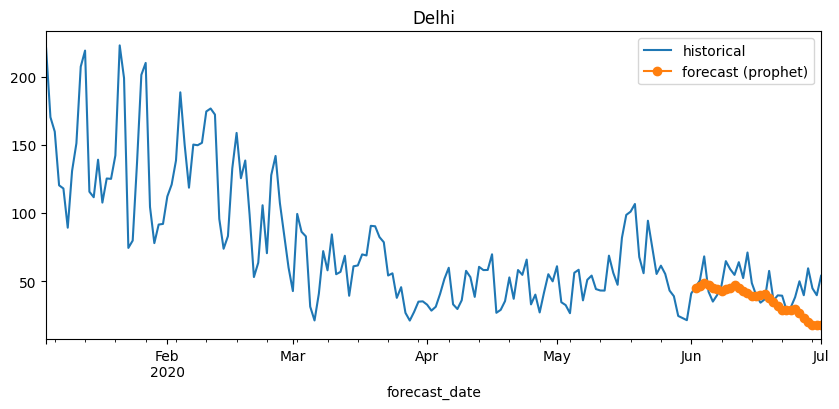

In [0]:
# CELL H — quick plot for sanity - Metric Chart
import matplotlib.pyplot as plt
city = top_cities[0]
hist = pdf[pdf['city']==city].set_index('date')['pm25'].sort_index()
fc_city = fc_all[(fc_all['city']==city) & (fc_all['model_name']=='prophet')].set_index('forecast_date')['yhat']
plt.figure(figsize=(10,4))
hist.tail(180).plot(label='historical')
fc_city.plot(label='forecast (prophet)', marker='o')
plt.title(city)
plt.legend()
plt.show()
